# Overview
The goal is to make a nice retinopathy model by using a pretrained inception v3 as a base and retraining some modified final layers with attention

This can be massively improved with 
* high-resolution images
* better data sampling
* ensuring there is no leaking between training and validation sets, ```sample(replace = True)``` is real dangerous
* better target variable (age) normalization
* pretrained models
* attention/related techniques to focus on areas

In [ ]:
[1]*10**10

In [1]:
import torch
torch.cuda.get_device_name(0)

ImportError: No module named torch

In [7]:
import tensorflow as tf
print(tf.__version__)

1.5.0


In [3]:
!pip install tensorflow==1.5
!pip install keras==2.1.6

DEPRECATION: Python 2.7 reached the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 is no longer maintained. pip 21.0 will drop support for Python 2.7 in January 2021. More details about Python 2 support in pip can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support pip 21.0 will remove support for this functionality.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_p27/bin/python -m pip install --upgrade pip' command.
DEPRECATION: Python 2.7 reached the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 is no longer maintained. pip 21.0 will drop support for Python 2.7 in January 2021. More details about Python 2 support in pip can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support pip 21.0 will remove support for this functionality.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_p27/bin/python -m pip 

In [4]:
!pip install request

DEPRECATION: Python 2.7 reached the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 is no longer maintained. pip 21.0 will drop support for Python 2.7 in January 2021. More details about Python 2 support in pip can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support pip 21.0 will remove support for this functionality.
ERROR: Could not find a version that satisfies the requirement request (from versions: none)
ERROR: No matching distribution found for request
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_p27/bin/python -m pip install --upgrade pip' command.


In [19]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # showing and rendering figures
# io related
from skimage.io import imread
import os
from glob import glob
# not needed in Kaggle, but required in Jupyter
%matplotlib inline

In [20]:
from google.colab import drive
drive.mount('/content/drive')
#drive.unmount('/content/drive')

ImportError: No module named colab

In [30]:
!pip install pathlib

DEPRECATION: Python 2.7 reached the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 is no longer maintained. pip 21.0 will drop support for Python 2.7 in January 2021. More details about Python 2 support in pip can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support pip 21.0 will remove support for this functionality.
     |████████████████████████████████| 49 kB 3.7 MB/s eta 0:00:011
  Created wheel for pathlib: filename=pathlib-1.0.1-py2-none-any.whl size=14347 sha256=d832fa07b7bc8741735352449c0e86f355ef03af4cc55ada3860433742d3c281
  Stored in directory: /home/ec2-user/.cache/pip/wheels/46/37/4f/332bcea757140ff34e14dec7be65931f544c7ac94eb671ae9f
Successfully built pathlib
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_p27/bin/python -m pip install --upgrade pip' command.


In [21]:
import logging
logging.basicConfig()
import boto3, re, sys, math, json, os, sagemaker, urllib2
from sagemaker import get_execution_role
#from smart_open import smart_open

from IPython.display import Image                 
from IPython.display import display               
from time import gmtime, strftime                 
from sagemaker.predictor import csv_serializer   

# Define IAM role
role = get_execution_role()
prefix = 'sagemaker/DEMO-xgboost-dm'
containers = {'us-west-2': '433757028032.dkr.ecr.us-west-2.amazonaws.com/xgboost:latest',
              'us-east-1': '811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest',
              'us-east-2': '825641698319.dkr.ecr.us-east-2.amazonaws.com/xgboost:latest',
              'eu-west-1': '685385470294.dkr.ecr.eu-west-1.amazonaws.com/xgboost:latest'} # each region has its XGBoost container
my_region = boto3.session.Session().region_name # set the region of the instance
print("Success - the MySageMakerInstance is in the " + my_region + " region. You will use the " + containers[my_region] + " container for your SageMaker endpoint.")

Success - the MySageMakerInstance is in the us-west-2 region. You will use the 433757028032.dkr.ecr.us-west-2.amazonaws.com/xgboost:latest container for your SageMaker endpoint.


In [23]:
s3 = boto3.client('s3')
obj = s3.get_object(Bucket='inception-v3', Key='trainLabels.csv')
data_body = obj["Body"].read()
import io 
data_stream = io.BytesIO(data_body)
df = pd.read_csv(data_stream,header=0,delimiter=",")
print(df)


             image  level
0          10_left      0
1         10_right      0
2          13_left      0
3         13_right      0
4          15_left      1
5         15_right      2
6          16_left      4
7         16_right      4
8          17_left      0
9         17_right      1
10         19_left      0
11        19_right      0
12         20_left      0
13        20_right      0
14         21_left      0
15        21_right      0
16         22_left      0
17        22_right      0
18         23_left      0
19        23_right      0
20         25_left      0
21        25_right      0
22         30_left      1
23        30_right      2
24         31_left      0
25        31_right      0
26         33_left      0
27        33_right      0
28         36_left      1
29        36_right      0
...            ...    ...
35096   44317_left      0
35097  44317_right      0
35098   44323_left      1
35099  44323_right      1
35100   44325_left      0
35101  44325_right      0
35102   4432

In [27]:
from StringIO import StringIO
import io
base_image_dir = os.path.join( 'drive','MyDrive','sample2')
s3 = boto3.client('s3')
obj = s3.get_object(Bucket='inception-v3', Key='sample2/trainLabels.csv')

#obj1 = obj['image']
#body = obj.read().decode('utf-8')
#retina_df = pd.read_csv(os.path.join(base_image_dir, 'trainLabels.csv'))

#retina_df = pd.DataFrame(list(obj.items()),columns = ['image','level'])
# retina_df = pd.re  ad_csv(io.BytesIO(obj.read()))
# print(retina_df)
retina_df = df
print(retina_df)
retina_df['PatientId'] = retina_df['image'].map(lambda x: x.split('_')[0])
retina_df['PatientId'] = retina_df['image'].map(lambda x: x.split('_')[0])
retina_df['path'] = retina_df['image'].map(lambda x: os.path.join('s3://inception-v3/sample2',
                                                         '{}.jpeg'.format(x)))
retina_df['exists'] = retina_df['path'].map(os.path.exists)
print(retina_df['exists'].sum(), 'images found of', retina_df.shape[0], 'total')
retina_df['eye'] = retina_df['image'].map(lambda x: 1 if x.split('_')[-1]=='left' else 0)
from keras.utils.np_utils import to_categorical
retina_df['level_cat'] = retina_df['level'].map(lambda x: to_categorical(x, 1+retina_df['level'].max()))

retina_df.dropna(inplace = True)
retina_df = retina_df[retina_df['exists']]
retina_df.sample(50)

             image  level
0          10_left      0
1         10_right      0
2          13_left      0
3         13_right      0
4          15_left      1
5         15_right      2
6          16_left      4
7         16_right      4
8          17_left      0
9         17_right      1
10         19_left      0
11        19_right      0
12         20_left      0
13        20_right      0
14         21_left      0
15        21_right      0
16         22_left      0
17        22_right      0
18         23_left      0
19        23_right      0
20         25_left      0
21        25_right      0
22         30_left      1
23        30_right      2
24         31_left      0
25        31_right      0
26         33_left      0
27        33_right      0
28         36_left      1
29        36_right      0
...            ...    ...
35096   44317_left      0
35097  44317_right      0
35098   44323_left      1
35099  44323_right      1
35100   44325_left      0
35101  44325_right      0
35102   4432

ImportError: cannot import name np_utils

# Examine the distribution of eye and severity

In [ ]:
retina_df[['level', 'eye']].hist(figsize = (10, 5))

# Split Data into Training and Validation

In [ ]:
from sklearn.model_selection import train_test_split
rr_df = retina_df[['PatientId', 'level']].drop_duplicates()
#radnom state is for shufffling
train_ids, valid_ids = train_test_split(rr_df['PatientId'], 
                                   test_size = 0.25, 
                                   random_state = 2018,
                                   #stratify = rr_df['level']
                                   )
#store train dataset
raw_train_df = retina_df[retina_df['PatientId'].isin(train_ids)]
#store test dataset
valid_df = retina_df[retina_df['PatientId'].isin(valid_ids)]
print('train', raw_train_df.shape[0], 'validation', valid_df.shape[0])

# Balance the distribution in the training set

In [ ]:
train_df = raw_train_df.groupby(['level', 'eye']).apply(lambda x: x.sample(75, replace = True)
                                                      ).reset_index(drop = True)
print('New Data Size:', train_df.shape[0], 'Old Size:', raw_train_df.shape[0])
train_df[['level', 'eye']].hist(figsize = (10, 5))

In [ ]:
import tensorflow as tf
from keras import backend as K
from keras.applications.inception_v3 import preprocess_input
import numpy as np
IMG_SIZE = (512, 512) # slightly smaller than vgg16 normally expects
def tf_image_loader(out_size, 
                      horizontal_flip = True, 
                      vertical_flip = False, 
                     random_brightness = True,
                     random_contrast = True,
                    random_saturation = True,
                    random_hue = True,
                      color_mode = 'rgb',
                       preproc_func = preprocess_input,
                       on_batch = False):
    def _func(X):
        with tf.name_scope('image_augmentation'):
            with tf.name_scope('input'):
                X = tf.image.decode_png(tf.read_file(X), channels = 3 if color_mode == 'rgb' else 0)
                X = tf.image.resize_images(X, out_size)
            with tf.name_scope('augmentation'):
                if horizontal_flip:
                    X = tf.image.random_flip_left_right(X)
                if vertical_flip:
                    X = tf.image.random_flip_up_down(X)
                if random_brightness:
                    X = tf.image.random_brightness(X, max_delta = 0.1)
                if random_saturation:
                    X = tf.image.random_saturation(X, lower = 0.75, upper = 1.5)
                if random_hue:
                    X = tf.image.random_hue(X, max_delta = 0.15)
                if random_contrast:
                    X = tf.image.random_contrast(X, lower = 0.75, upper = 1.5)
                return preproc_func(X)
    if on_batch: 
        # we are meant to use it on a batch
        def _batch_func(X, y):
            return tf.map_fn(_func, X), y
        return _batch_func
    else:
        # we apply it to everything
        def _all_func(X, y):
            return _func(X), y         
        return _all_func
    
def tf_augmentor(out_size,
                intermediate_size = (640, 640),
                 intermediate_trans = 'crop',
                 batch_size = 16,
                   horizontal_flip = True, 
                  vertical_flip = False, 
                 random_brightness = True,
                 random_contrast = True,
                 random_saturation = True,
                    random_hue = True,
                  color_mode = 'rgb',
                   preproc_func = preprocess_input,
                   min_crop_percent = 0.001,
                   max_crop_percent = 0.005,
                   crop_probability = 0.5,
                   rotation_range = 10):
    
    load_ops = tf_image_loader(out_size = intermediate_size, 
                               horizontal_flip=horizontal_flip, 
                               vertical_flip=vertical_flip, 
                               random_brightness = random_brightness,
                               random_contrast = random_contrast,
                               random_saturation = random_saturation,
                               random_hue = random_hue,
                               color_mode = color_mode,
                               preproc_func = preproc_func,
                               on_batch=False)
    def batch_ops(X, y):
        batch_size = tf.shape(X)[0]
        with tf.name_scope('transformation'):
            # code borrowed from https://becominghuman.ai/data-augmentation-on-gpu-in-tensorflow-13d14ecf2b19
            # The list of affine transformations that our image will go under.
            # Every element is Nx8 tensor, where N is a batch size.
            transforms = []
            identity = tf.constant([1, 0, 0, 0, 1, 0, 0, 0], dtype=tf.float32)
            if rotation_range > 0:
                angle_rad = rotation_range / 180 * np.pi
                angles = tf.random_uniform([batch_size], -angle_rad, angle_rad)
                transforms += [tf.contrib.image.angles_to_projective_transforms(angles, intermediate_size[0], intermediate_size[1])]

            if crop_probability > 0:
                crop_pct = tf.random_uniform([batch_size], min_crop_percent, max_crop_percent)
                left = tf.random_uniform([batch_size], 0, intermediate_size[0] * (1.0 - crop_pct))
                top = tf.random_uniform([batch_size], 0, intermediate_size[1] * (1.0 - crop_pct))
                crop_transform = tf.stack([
                      crop_pct,
                      tf.zeros([batch_size]), top,
                      tf.zeros([batch_size]), crop_pct, left,
                      tf.zeros([batch_size]),
                      tf.zeros([batch_size])
                  ], 1)
                coin = tf.less(tf.random_uniform([batch_size], 0, 1.0), crop_probability)
                transforms += [tf.where(coin, crop_transform, tf.tile(tf.expand_dims(identity, 0), [batch_size, 1]))]
            if len(transforms)>0:
                X = tf.contrib.image.transform(X,
                      tf.contrib.image.compose_transforms(*transforms),
                      interpolation='BILINEAR') # or 'NEAREST'
            if intermediate_trans=='scale':
                X = tf.image.resize_images(X, out_size)
            elif intermediate_trans=='crop':
                X = tf.image.resize_image_with_crop_or_pad(X, out_size[0], out_size[1])
            else:
                raise ValueError('Invalid Operation {}'.format(intermediate_trans))
            return X, y
    def _create_pipeline(in_ds):
        batch_ds = in_ds.map(load_ops, num_parallel_calls=4).batch(batch_size)
        return batch_ds.map(batch_ops)
    return _create_pipeline

In [ ]:
def flow_from_dataframe(idg, 
                        in_df, 
                        path_col,
                        y_col, 
                        shuffle = True, 
                        color_mode = 'rgb'):
    files_ds = tf.data.Dataset.from_tensor_slices((in_df[path_col].values, 
                                                   np.stack(in_df[y_col].values,0)))
    in_len = in_df[path_col].values.shape[0]
    while True:
        if shuffle:
            files_ds = files_ds.shuffle(in_len) # shuffle the whole dataset
        
        next_batch = idg(files_ds).repeat().make_one_shot_iterator().get_next()
        for i in range(max(in_len//32,1)):
            # NOTE: if we loop here it is 'thread-safe-ish' if we loop on the outside it is completely unsafe
            yield K.get_session().run(next_batch)

In [ ]:
batch_size = 48
core_idg = tf_augmentor(out_size = IMG_SIZE, 
                        color_mode = 'rgb', 
                        vertical_flip = True,
                        crop_probability=0.0, # crop doesn't work yet
                        batch_size = batch_size) 
valid_idg = tf_augmentor(out_size = IMG_SIZE, color_mode = 'rgb', 
                         crop_probability=0.0, 
                         horizontal_flip = False, 
                         vertical_flip = False, 
                         random_brightness = False,
                         random_contrast = False,
                         random_saturation = False,
                         random_hue = False,
                         rotation_range = 0,
                        batch_size = batch_size)

train_gen = flow_from_dataframe(core_idg, train_df, 
                             path_col = 'path',
                            y_col = 'level_cat')

valid_gen = flow_from_dataframe(valid_idg, valid_df, 
                             path_col = 'path',
                            y_col = 'level_cat') # we can use much larger batches for evaluation

# Validation Set
We do not perform augmentation at all on these images

In [ ]:
t_x, t_y = next(valid_gen)
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(np.clip(c_x*127+127, 0, 255).astype(np.uint8))
    c_ax.set_title('Severity {}'.format(np.argmax(c_y, -1)))
    c_ax.axis('off')

# Training Set
These are augmented and a real mess

In [ ]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(np.clip(c_x*127+127, 0, 255).astype(np.uint8))
    c_ax.set_title('Severity {}'.format(np.argmax(c_y, -1)))
    c_ax.axis('off')

# Attention Model
The basic idea is that a Global Average Pooling is too simplistic since some of the regions are more relevant than others. So we build an attention mechanism to turn pixels in the GAP on an off before the pooling and then rescale (Lambda layer) the results based on the number of pixels. The model could be seen as a sort of 'global weighted average' pooling. There is probably something published about it and it is very similar to the kind of attention models used in NLP.
It is largely based on the insight that the winning solution annotated and trained a UNET model to segmenting the hand and transforming it. This seems very tedious if we could just learn attention.

In [ ]:
from keras.applications.vgg16 import VGG16 as PTModel
from keras.applications.inception_resnet_v2 import InceptionResNetV2 as PTModel
from keras.applications.inception_v3 import InceptionV3 as PTModel
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda
from keras.models import Model
in_lay = Input(t_x.shape[1:])
base_pretrained_model = PTModel(input_shape =  t_x.shape[1:], include_top = False, weights = 'imagenet')
base_pretrained_model.trainable = False
pt_depth = base_pretrained_model.get_output_shape_at(0)[-1]
pt_features = base_pretrained_model(in_lay)
from keras.layers import BatchNormalization
bn_features = BatchNormalization()(pt_features)

# here we do an attention mechanism to turn pixels in the GAP on an off

attn_layer = Conv2D(64, kernel_size = (1,1), padding = 'same', activation = 'relu')(Dropout(0.5)(bn_features))
attn_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = Conv2D(8, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = Conv2D(1, 
                    kernel_size = (1,1), 
                    padding = 'valid', 
                    activation = 'sigmoid')(attn_layer)
# fan it out to all of the channels
up_c2_w = np.ones((1, 1, 1, pt_depth))
up_c2 = Conv2D(pt_depth, kernel_size = (1,1), padding = 'same', 
               activation = 'linear', use_bias = False, weights = [up_c2_w])
up_c2.trainable = False
attn_layer = up_c2(attn_layer)

mask_features = multiply([attn_layer, bn_features])
gap_features = GlobalAveragePooling2D()(mask_features)
gap_mask = GlobalAveragePooling2D()(attn_layer)
# to account for missing values from the attention model
gap = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])
gap_dr = Dropout(0.25)(gap)
dr_steps = Dropout(0.25)(Dense(128, activation = 'relu')(gap_dr))
out_layer = Dense(t_y.shape[-1], activation = 'softmax')(dr_steps)
retina_model = Model(inputs = [in_lay], outputs = [out_layer])
from keras.metrics import top_k_categorical_accuracy
def top_2_accuracy(in_gt, in_pred):
    return top_k_categorical_accuracy(in_gt, in_pred, k=2)

retina_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                           metrics = ['categorical_accuracy', top_2_accuracy])
retina_model.summary()

87916544/87910968 [==============================] - 2s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 14, 14, 2048) 21802784    input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 14, 14, 2048) 8192        inception_v3[1][0]               
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 14, 14, 2048) 0           batch_normalization_95[0][0]     
____________________________________________

In [3]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="/content/drive/MyDrive/savedModels/{}_weights.best.hdf5".format('retina')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, verbose=1, mode='auto', min_delta=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=6) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

ImportError: No module named keras.callbacks

In [ ]:
!rm -rf ~/.keras # clean up before starting training

In [ ]:
# retina_model.fit_generator(train_gen, 
#                            steps_per_epoch = train_df.shape[0]//batch_size,
#                            validation_data = valid_gen, 
#                            #validation_steps = 5,
#                            validation_steps = valid_df.shape[0]/batch_size,
#                            epochs = 1, 
#                            callbacks = callbacks_list,
#                              workers = 0, # tf-generators are not thread-safe
#                              use_multiprocessing=False, 
#                              max_queue_size = 0
#                             )

Epoch 1/1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# load the best version of the model
# retina_model.load_weights(weight_path)
# retina_model.save('/content/drive/MyDrive/savedModels/full_retina_model.h5')
# retina_model.save('full_retina_model.h5')

In [ ]:
# retina_model.fit_generator(train_gen, 
#                            steps_per_epoch = train_df.shape[0]//batch_size,
#                            validation_data = valid_gen, 
#                            #validation_steps = 5,
#                            validation_steps = valid_df.shape[0]/batch_size,
#                            epochs = 1, 
#                            callbacks = callbacks_list,
#                              workers = 0, # tf-generators are not thread-safe
#                              use_multiprocessing=False, 
#                              max_queue_size = 0
#                             )

Epoch 1/1
15/15 [==============================] - 2605s 174s/step - loss: 0.7930 - categorical_accuracy: 0.7278 - top_2_accuracy: 0.8875 - val_loss: 2.1511 - val_categorical_accuracy: 0.2308 - val_top_2_accuracy: 0.5385

Epoch 00001: val_loss did not improve from 1.82747


In [ ]:
# retina_model.save('/content/drive/MyDrive/savedModels/full_retina_model.h5')
retina_model.load_weights(weight_path)

In [ ]:
retina_model.load_weights(weight_path)
retina_model.fit_generator(train_gen, 
                           steps_per_epoch = train_df.shape[0]//batch_size,
                           validation_data = valid_gen, 
                           #validation_steps = 5,
                           validation_steps = valid_df.shape[0]/batch_size,
                           epochs = 5, 
                           callbacks = callbacks_list,
                             workers = 0, # tf-generators are not thread-safe
                             use_multiprocessing=False, 
                             max_queue_size = 0
                            )

Epoch 1/5
15/15 [==============================] - 2953s 197s/step - loss: 1.8053 - categorical_accuracy: 0.3381 - top_2_accuracy: 0.5629 - val_loss: 1.7177 - val_categorical_accuracy: 0.2669 - val_top_2_accuracy: 0.5418

Epoch 00001: val_loss improved from inf to 1.71772, saving model to /content/drive/MyDrive/savedModels/retina_weights.best.hdf5
Epoch 2/5
15/15 [==============================] - 2863s 191s/step - loss: 1.4541 - categorical_accuracy: 0.3653 - top_2_accuracy: 0.6042 - val_loss: 1.6269 - val_categorical_accuracy: 0.2869 - val_top_2_accuracy: 0.5578

Epoch 00002: val_loss improved from 1.71772 to 1.62687, saving model to /content/drive/MyDrive/savedModels/retina_weights.best.hdf5
Epoch 3/5
15/15 [==============================] - 2853s 190s/step - loss: 1.4329 - categorical_accuracy: 0.3796 - top_2_accuracy: 0.6356 - val_loss: 1.5247 - val_categorical_accuracy: 0.3021 - val_top_2_accuracy: 0.5938

Epoch 00003: val_loss improved from 1.62687 to 1.52473, saving model to /c

In [ ]:
# After first training
retina_model.load_weights(weight_path)
retina_model.save('/content/drive/MyDrive/savedModels/full_retina_model.h5')
retina_model.save('full_retina_model.h5')

In [ ]:
##### create one fixed dataset for evaluating
from tqdm import tqdm_notebook
# fresh valid gen
valid_gen = flow_from_dataframe(valid_idg, valid_df, 
                             path_col = 'path',
                            y_col = 'level_cat') 
#vbatch_count = (valid_df.shape[0]//batch_size-1)
vbatch_count = (valid_df.shape[0])
out_size = vbatch_count*batch_size
test_X = np.zeros((out_size,)+t_x.shape[1:], dtype = np.float32)
test_Y = np.zeros((out_size,)+t_y.shape[1:], dtype = np.float32)
for i, (c_x, c_y) in zip(tqdm_notebook(range(vbatch_count)), 
                         valid_gen):
    j = i*batch_size
    test_X[j:(j+c_x.shape[0])] = c_x
    test_Y[j:(j+c_x.shape[0])] = c_y

NameError: ignored

# Show Attention
Did our attention model learn anything useful?

In [ ]:
# get the attention layer since it is the only one with a single output dim
for attn_layer in retina_model.layers:
    c_shape = attn_layer.get_output_shape_at(0)
    if len(c_shape)==4:
        if c_shape[-1]==1:
            print(attn_layer)
            break

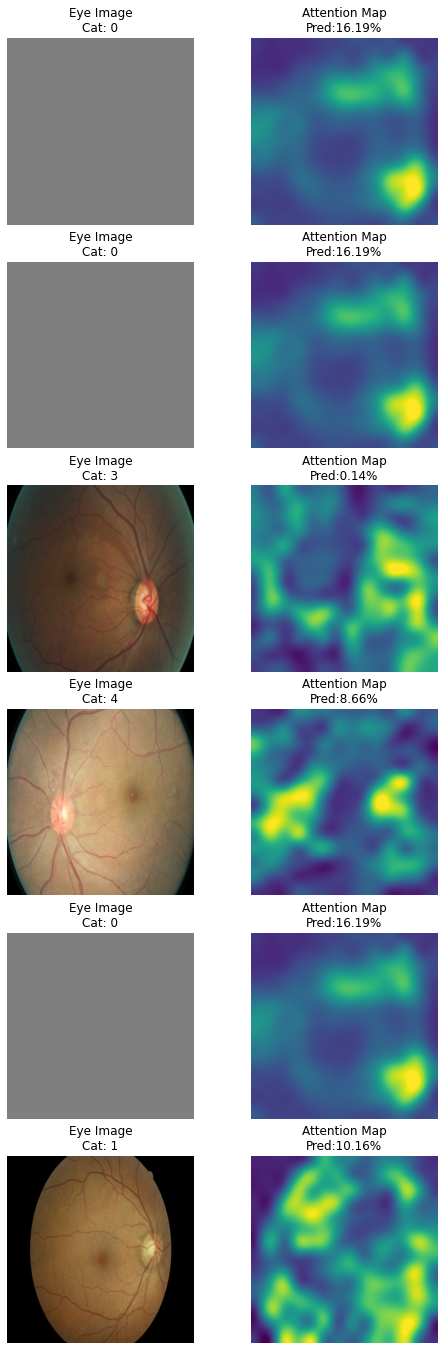

In [ ]:
import keras.backend as K
rand_idx = np.random.choice(range(len(test_X)), size = 6)
attn_func = K.function(inputs = [retina_model.get_input_at(0), K.learning_phase()],
           outputs = [attn_layer.get_output_at(0)]
          )
fig, m_axs = plt.subplots(len(rand_idx), 2, figsize = (8, 4*len(rand_idx)))
[c_ax.axis('off') for c_ax in m_axs.flatten()]
for c_idx, (img_ax, attn_ax) in zip(rand_idx, m_axs):
    cur_img = test_X[c_idx:(c_idx+1)]
    attn_img = attn_func([cur_img, 0])[0]
    img_ax.imshow(np.clip(cur_img[0,:,:,:]*127+127, 0, 255).astype(np.uint8))
    attn_ax.imshow(attn_img[0, :, :, 0]/attn_img[0, :, :, 0].max(), cmap = 'viridis', 
                   vmin = 0, vmax = 1, 
                   interpolation = 'lanczos')
    real_cat = np.argmax(test_Y[c_idx, :])
    img_ax.set_title('Eye Image\nCat:%2d' % (real_cat))
    pred_cat = retina_model.predict(cur_img)
    attn_ax.set_title('Attention Map\nPred:%2.2f%%' % (100*pred_cat[0,real_cat]))
fig.savefig('attention_map.png', dpi = 300)

# Evaluate the results
Here we evaluate the results by loading the best version of the model and seeing how the predictions look on the results. We then visualize spec

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
pred_Y = retina_model.predict(test_X, batch_size = 32, verbose = True)
pred_Y_cat = np.argmax(pred_Y, -1)
test_Y_cat = np.argmax(test_Y, -1)
print('Accuracy on Test Data: %2.2f%%' % (accuracy_score(test_Y_cat, pred_Y_cat)))
print(classification_report(test_Y_cat, pred_Y_cat))

1248/1248 [==============================] - 3289s 3s/step
Accuracy on Test Data: 0.15%
              precision    recall  f1-score   support

           0       0.14      0.04      0.06       676
           1       0.04      0.33      0.06        78
           2       0.00      0.00      0.00       104
           3       0.00      0.00      0.00       182
           4       0.38      0.62      0.48       208

    accuracy                           0.15      1248
   macro avg       0.11      0.20      0.12      1248
weighted avg       0.14      0.15      0.12      1248



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


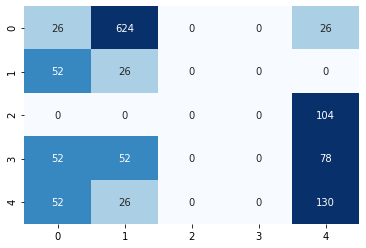

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(test_Y_cat, pred_Y_cat), 
            annot=True, fmt="d", cbar = False, cmap = plt.cm.Blues, vmax = test_X.shape[0]//16)

# ROC Curve for healthy vs sick
Here we make an ROC curve for healthy (```severity == 0```) and sick (```severity>0```) to see how well the model works at just identifying the disease

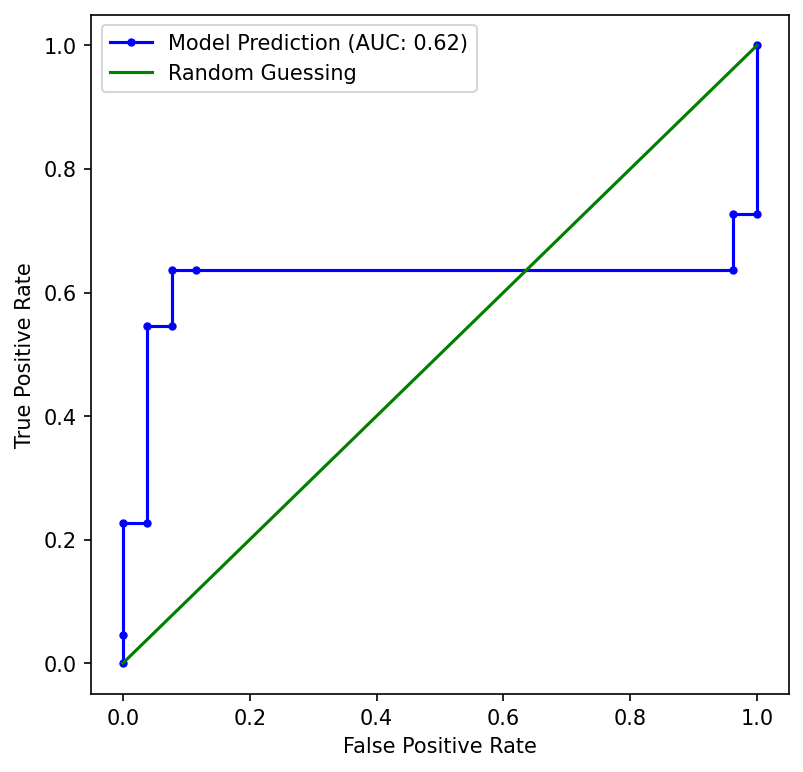

In [ ]:

from sklearn.metrics import roc_curve, roc_auc_score
sick_vec = test_Y_cat>0
sick_score = np.sum(pred_Y[:,1:],1)
fpr, tpr, _ = roc_curve(sick_vec, sick_score)
fig, ax1 = plt.subplots(1,1, figsize = (6, 6), dpi = 150)
ax1.plot(fpr, tpr, 'b.-', label = 'Model Prediction (AUC: %2.2f)' % roc_auc_score(sick_vec, sick_score))
ax1.plot(fpr, fpr, 'g-', label = 'Random Guessing')
ax1.legend()
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate');

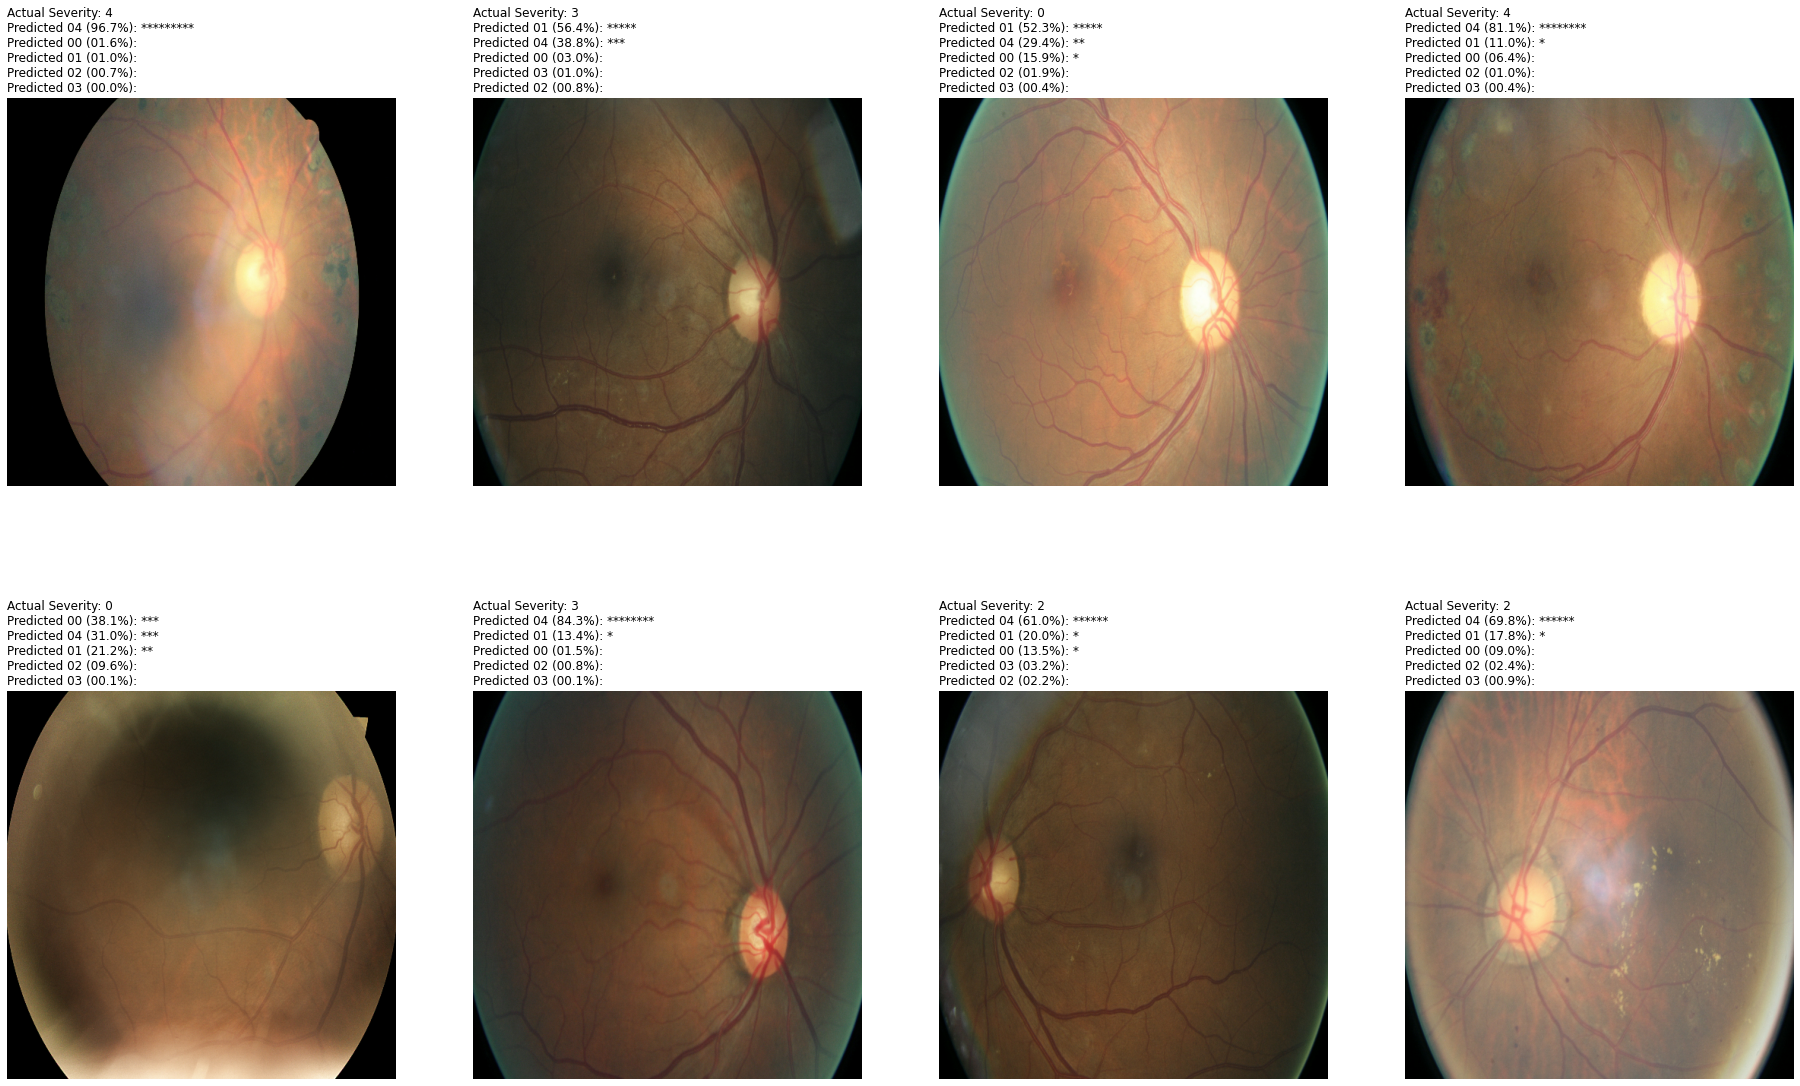

In [ ]:
fig, m_axs = plt.subplots(2, 4, figsize = (32, 20))
for (idx, c_ax) in enumerate(m_axs.flatten()):
    c_ax.imshow(np.clip(test_X[idx]*127+127,0 , 255).astype(np.uint8), cmap = 'bone')
    c_ax.set_title('Actual Severity: {}\n{}'.format(test_Y_cat[idx], 
                                                           '\n'.join(['Predicted %02d (%04.1f%%): %s' % (k, 100*v, '*'*int(10*v)) for k, v in sorted(enumerate(pred_Y[idx]), key = lambda x: -1*x[1])])), loc='left')
    c_ax.axis('off')
fig.savefig('trained_img_predictions.png', dpi = 300)

In [9]:
!git init


Reinitialized existing Git repository in /home/ec2-user/SageMaker/.git/


In [3]:
!git commit -m "first commit"

On branch master

Initial commit

Untracked files:
	.ipynb
	.ipynb_checkpoints/
	Untitled.ipynb
	inceptionv3_for_retinopathy_gpu_hr.ipynb
	trainLabels.csv

nothing added to commit but untracked files present


In [10]:
!sudo git add . 

In [11]:
!git commit -m "first commit"

[master (root-commit) 65a7cd7] first commit
 Committer: EC2 Default User <ec2-user@ip-172-16-24-211.us-west-2.compute.internal>
Your name and email address were configured automatically based
on your username and hostname. Please check that they are accurate.
You can suppress this message by setting them explicitly:

    git config --global user.name "Your Name"
    git config --global user.email you@example.com

After doing this, you may fix the identity used for this commit with:

    git commit --amend --reset-author

 7 files changed, 42002 insertions(+)
 create mode 100644 .ipynb
 create mode 100644 .ipynb_checkpoints/.ipynb-checkpoint
 create mode 100644 .ipynb_checkpoints/Untitled-checkpoint.ipynb
 create mode 100644 .ipynb_checkpoints/inceptionv3_for_retinopathy_gpu_hr-checkpoint.ipynb
 create mode 100644 Untitled.ipynb
 create mode 100644 inceptionv3_for_retinopathy_gpu_hr.ipynb
 create mode 100644 trainLabels.csv


In [12]:
!git remote add origin https://github.com/noelalam9999/inception-v3.git

In [ ]:
!git push -u origin main
noelalam9999

Username for 'https://github.com/noelalam9999/inception-v3.git': 

In [ ]:
noelalam9999